In [1]:
from random import sample,choice
from time import time
import multiprocessing
import xarray as xr
import numpy as np
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
ds_range = xr.open_dataset('data/processed/range-pd-sync4.nc')
ds_stream = xr.open_dataset('data/processed/stream-pd-int2.nc')

latitude = ds_range.lat.values
longitude = ds_range.lon.values
# time = ds_range.time.values

r_pd = ds_range.pd.values
s_pd = ds_stream.pd.values
r_pd.shape

(2688, 519, 232)

In [3]:
R_e = 6378.1e3 # equatorial radius of earth
dlon_rad = abs(longitude[0]-longitude[1])*2*np.pi/360 # resolution
dlat_rad = abs(latitude[0]-latitude[1])*2*np.pi/360
lat_rad = (latitude*2*np.pi/360) - dlat_rad/2
last = lat_rad[-1]+dlat_rad
lat_rad = np.append(lat_rad,last)
lon_lin = dlon_rad*R_e*np.sin(np.pi-2*lat_rad)/(2*np.sin(lat_rad))
lat_lin = R_e*dlat_rad
# r_area = lat_lin*lon_lin # trapezium not rectangle

r_area = np.zeros((len(latitude)))
for j in range(len(latitude)):
    r_area[j] = (lon_lin[j]+lon_lin[j+1])*lat_lin/2
    

r_power = np.zeros((2688,519,232))
for j in range(len(latitude)):
    r_power[:,j,:] = r_pd[:,j,:]*r_area[j]
    

In [4]:
lon_av = r_area/lat_lin # longitude values for stream
D = 10
n = (lat_lin/(15*D))+1
N = ((lon_av/D)+3)/4
N = N.astype(int)
s_area = int(n)*N*np.pi*(D**2)/4

s_power = np.zeros((2688,519,232))
for j in range(len(latitude)):
    s_power[:,j,:] = s_pd[:,j,:]*s_area[j]
    

In [5]:
range_xr = xr.Dataset({
    'power': xr.DataArray(
        data=r_power,
        coords={'time': ds_range.time.values,
                'lat': latitude,
                'lon': longitude},
        dims=['time','lat','lon'])})


stream_xr = xr.Dataset({
    'power': xr.DataArray(
        data=s_power,
        coords={'time': ds_range.time.values,
                'lat': latitude,
                'lon': longitude},
        dims=['time','lat','lon'])})




range_xr['power'] = range_xr.power.assign_attrs(units='W')
range_xr['power'] = range_xr.power.assign_attrs(long_name='power')
range_xr['lat'] = range_xr.lat.assign_attrs(units='degrees')
range_xr['lat'] = range_xr.lat.assign_attrs(long_name='latitude')
range_xr['lon'] = range_xr.lon.assign_attrs(units='degrees')
range_xr['lon'] = range_xr.lon.assign_attrs(long_name='longitude')

stream_xr['power'] = stream_xr.power.assign_attrs(units='W')
stream_xr['power'] = stream_xr.power.assign_attrs(long_name='power')
stream_xr['lat'] = stream_xr.lat.assign_attrs(units='degrees')
stream_xr['lat'] = stream_xr.lat.assign_attrs(long_name='latitude')
stream_xr['lon'] = stream_xr.lon.assign_attrs(units='degrees')
stream_xr['lon'] = stream_xr.lon.assign_attrs(long_name='longitude')





range_xr.to_netcdf(path=f'data/processed/range-power.nc')
stream_xr.to_netcdf(path=f'data/processed/stream-power.nc') 

In [3]:
# r_area = 3.8*3e6 # 3.8 +/- 0.4 km longitude
# s_area = 150000

# r_power = r_pd*r_area
# s_power = s_pd*s_area

In [4]:
ds_range_pow = xr.open_dataset('data/processed/range-power.nc')
ds_stream_pow = xr.open_dataset('data/processed/stream-power.nc')

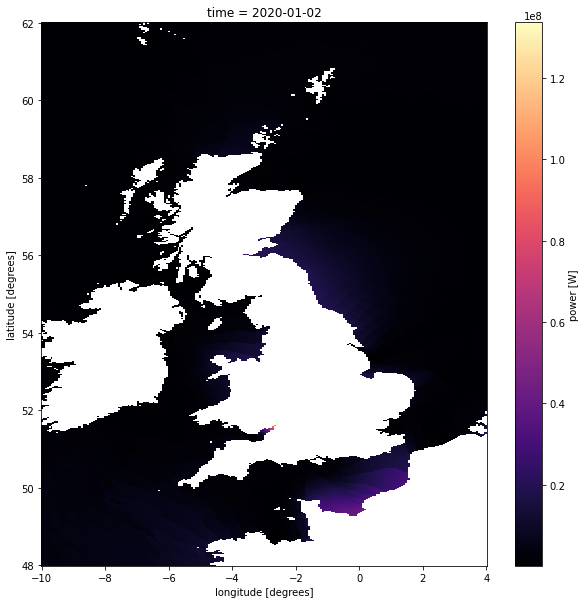

In [9]:
target_time = '2020-01-02T00:00:00.000000000'  
ds_range_pow.power.sel(time=target_time,method='nearest').plot(size=10,aspect=1,cmap='magma') 

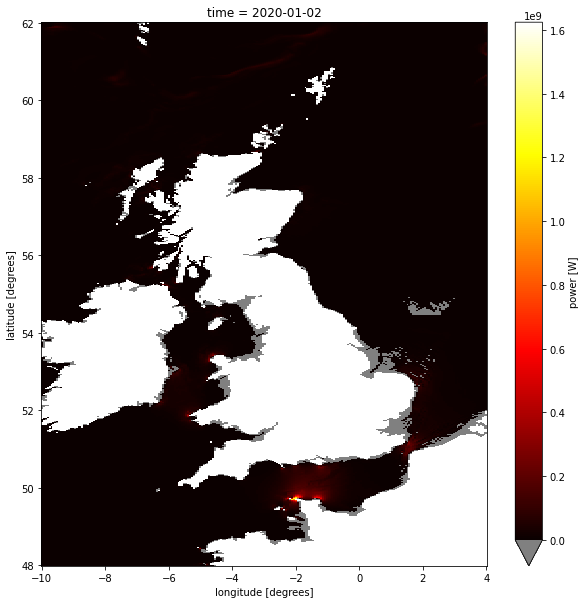

In [10]:
cmap = mpl.cm.get_cmap('hot').copy()
cmap.set_under('gray')

target_time = '2020-01-02T00:00:00.000000000' 
ds_stream_pow.power.sel(time=target_time,method='nearest').plot(size=10,aspect=1,vmin=0,cmap=cmap)  

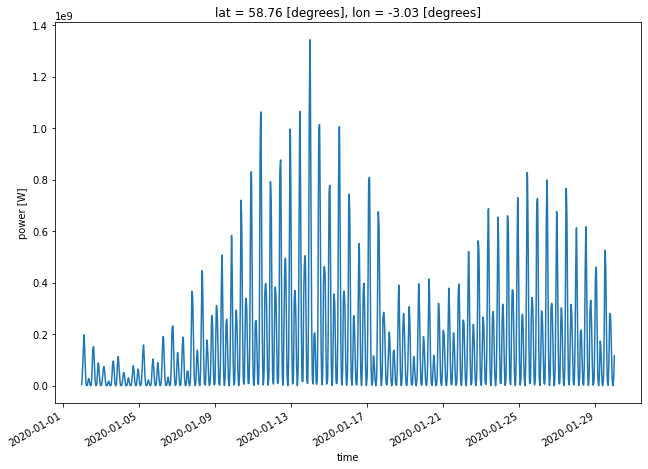

In [15]:
long = -3.06
lat = 58.75

ds_stream_pow.power.sel(lon=long,lat=lat,method='nearest').plot(size=7)

In [7]:
len(latitude)*len(longitude)

120408

In [8]:
not_nan_range = r_power[0,:,:]
not_nan_range = not_nan_range[not_nan_range>=0]
len(not_nan_range)

84318

In [9]:
not_nan_stream = s_power[0,:,:]
not_nan_stream = not_nan_stream[not_nan_stream>=0]
len(not_nan_stream)

81018

In [ ]:
### only needs running once

# df = pandas.DataFrame(columns=['flag','lat_index','lon_index'], index=range(len(not_nan_range)+len(not_nan_stream)))



# count = -1

# for j in range(len(latitude)):
#     for k in range(len(longitude)):
        
#         if r_pd[0,j,k] >= 0:
#             count += 1
#             df['flag'][count] = 'r'
#             df['lat_index'][count] = j
#             df['lon_index'][count] = k
            
            
#         if s_pd[0,j,k] >= 0:
#             count += 1
#             df['flag'][count] = 's'
#             df['lat_index'][count] = j
#             df['lon_index'][count] = k
            
            
# # df.to_csv('data/processed/not-nan.csv',index=False)

In [4]:
not_nan = pandas.read_csv('data/processed/not-nan.csv')
df_idx = list(not_nan.index)
# not_nan = not_nan[not_nan['flag']=='r'] # only range
# not_nan = not_nan[not_nan['flag']=='s'] # only stream

In [11]:
not_nan.index

RangeIndex(start=0, stop=165336, step=1)

In [12]:
### mean power (power, not power density) across time period of data

r_mean_power = np.zeros((r_power.shape[1],r_power.shape[2]))
r_mean_power[:] = np.nan
s_mean_power = np.zeros((s_power.shape[1],s_power.shape[2]))
s_mean_power[:] = np.nan

for i in range(r_power.shape[1]):
    for j in range(r_power.shape[2]):
        if np.isnan(r_power[0,i,j]) == True:
            pass
        else:
            r_mean_power[i,j] = np.mean(r_power[:,i,j])
            
            
            
for i in range(s_power.shape[1]):
    for j in range(s_power.shape[2]):
        if np.isnan(s_power[0,i,j]) == True:
            pass
        elif s_power[0,i,j] < 0:
            s_mean_power[i,j] = -10
        else:
            s_mean_power[i,j] = np.mean(s_power[:,i,j])
                

In [13]:
range_xr = xr.Dataset({
    'power': xr.DataArray(
        data=r_mean_power,
        coords={'lat': latitude,
                'lon': longitude},
        dims=['lat','lon'])})


stream_xr = xr.Dataset({
    'power': xr.DataArray(
        data=s_mean_power,
        coords={'lat': latitude,
                'lon': longitude},
        dims=['lat','lon'])})




range_xr['power'] = range_xr.power.assign_attrs(units='W')
range_xr['power'] = range_xr.power.assign_attrs(long_name='mean power')
range_xr['lat'] = range_xr.lat.assign_attrs(units='degrees')
range_xr['lat'] = range_xr.lat.assign_attrs(long_name='latitude')
range_xr['lon'] = range_xr.lon.assign_attrs(units='degrees')
range_xr['lon'] = range_xr.lon.assign_attrs(long_name='longitude')

stream_xr['power'] = stream_xr.power.assign_attrs(units='W')
stream_xr['power'] = stream_xr.power.assign_attrs(long_name='mean power')
stream_xr['lat'] = stream_xr.lat.assign_attrs(units='degrees')
stream_xr['lat'] = stream_xr.lat.assign_attrs(long_name='latitude')
stream_xr['lon'] = stream_xr.lon.assign_attrs(units='degrees')
stream_xr['lon'] = stream_xr.lon.assign_attrs(long_name='longitude')





range_xr.to_netcdf(path=f'data/processed/range-mean-power3.nc')
stream_xr.to_netcdf(path=f'data/processed/stream-mean-power3.nc') # no version 2

In [3]:
ds_range_mean = xr.open_dataset('data/processed/range-mean-power3.nc')
ds_stream_mean = xr.open_dataset('data/processed/stream-mean-power3.nc')


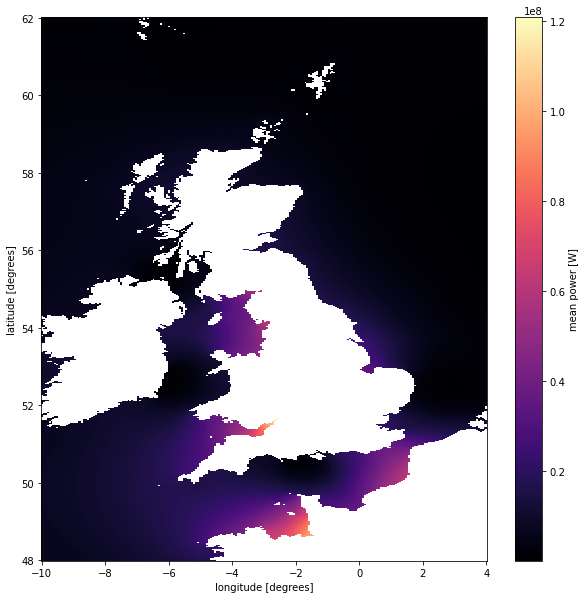

In [5]:
cmap = mpl.cm.get_cmap('magma').copy()
ds_range_mean.power.plot(size=10,aspect=1,cmap=cmap) 

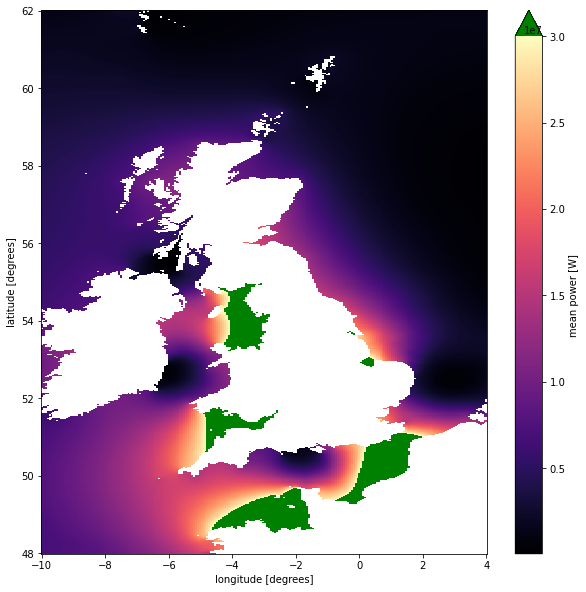

In [6]:
cmap = mpl.cm.get_cmap('magma').copy()
# cmap.set_under('black')
cmap.set_over('green')


ds_range_mean.power.plot(size=10,aspect=1,vmax=3e7,cmap=cmap)  

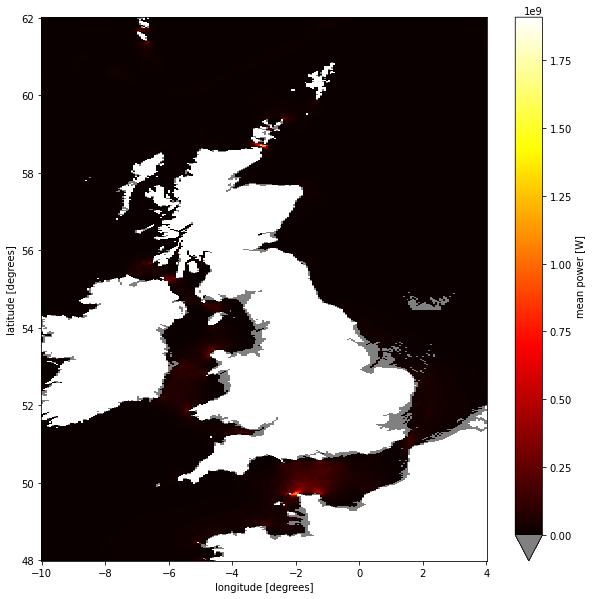

In [3]:
cmap = mpl.cm.get_cmap('hot').copy()
cmap.set_under('gray')

ds_stream_mean.power.plot(size=10,aspect=1,vmin=0,cmap=cmap)  

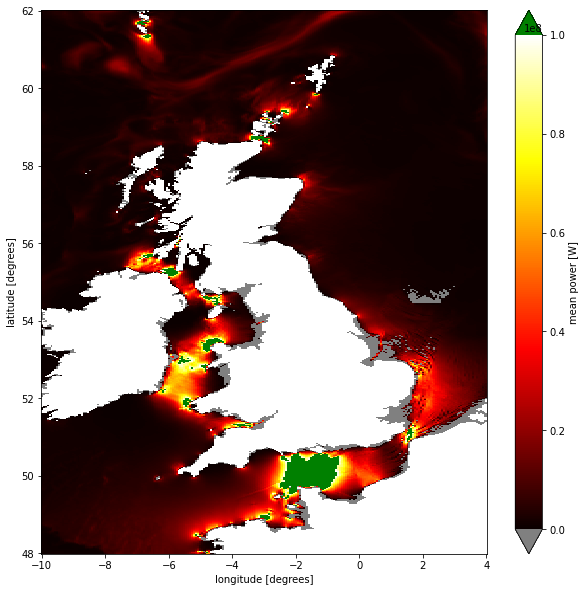

In [17]:
cmap = mpl.cm.get_cmap('hot').copy()
cmap.set_under('gray')
cmap.set_over('green')

ds_stream_mean.power.plot(size=10,aspect=1,vmin=0,vmax=1e8,cmap=cmap)  

In [18]:
# (1e7/r_area)*365*24

7684.21052631579

In [19]:
# (1e7/s_area)*365*24

584000.0

In [11]:
r_thres = ds_range_mean.power.values
r_thres = r_thres[r_thres>=5e7]
len(r_thres)

871

In [4]:
s_thres = ds_stream_mean.power.values
s_thres = s_thres[s_thres>=1e8]
len(s_thres)

1172

In [13]:
### only needs running once

df = pandas.DataFrame(columns=['flag','lat_index','lon_index'], index=range(len(r_thres)+len(s_thres)))

r_av = ds_range_mean.power.values
s_av = ds_stream_mean.power.values

count = -1

for j in range(len(latitude)):
    for k in range(len(longitude)):
        
        if r_av[j,k] >= 5e7:
            count += 1
            df['flag'][count] = 'r'
            df['lat_index'][count] = j
            df['lon_index'][count] = k
            
            
        if s_av[j,k] >= 5e7:
            count += 1
            df['flag'][count] = 's'
            df['lat_index'][count] = j
            df['lon_index'][count] = k
            
            
df.to_csv('data/processed/5e7.csv',index=False)

In [6]:
### only needs running once

df = pandas.DataFrame(columns=['flag','lat_index','lon_index'], index=range(len(s_thres)))

s_av = ds_stream_mean.power.values

count = -1

for j in range(len(latitude)):
    for k in range(len(longitude)):
        
        if s_av[j,k] >= 1e8:
            count += 1
            df['flag'][count] = 's'
            df['lat_index'][count] = j
            df['lon_index'][count] = k
            
            
# df.to_csv('data/processed/1e8.csv',index=False)

thres = pandas.read_csv('data/processed/1e8.csv')
thres

,flag,lat_index,lon_index
0,s,1,86
1,s,16,82
2,s,17,80
3,s,18,80
4,s,32,117
...,...,...,...
1167,s,508,51
1168,s,508,52
1169,s,508,53
1170,s,508,54


In [14]:
thres = pandas.read_csv('data/processed/5e7.csv')
thres = thres[thres['flag']=='r'] # only range
# not_nan = not_nan[not_nan['flag']=='s'] # only stream
df_idx = list(thres.index)
thres

,flag,lat_index,lon_index
25,r,20,121
26,r,21,120
27,r,21,121
28,r,21,122
30,r,22,119
...,...,...,...
3640,r,257,111
3641,r,257,113
3642,r,257,114
3643,r,258,106


In [3]:
ds = xr.open_dataset('data/processed/map.nc')
s_space = ds.empty.values
thres = pandas.read_csv('data/processed/1e8.csv')
# thres = thres[thres['flag']=='r']

for j in range(len(thres)):
    s_space[thres.iloc[j]['lat_index'],thres.iloc[j]['lon_index']] = 10

In [5]:
placement_xr = xr.Dataset({
    'space': xr.DataArray(
        data=s_space,
        coords={'lat': ds.lat.values,
                'lon': ds.lon.values},
        dims=['lat','lon'])})



placement_xr.to_netcdf(path=f'data/processed/stream-search-space-1e8.nc')

In [7]:
ds = xr.open_dataset('data/processed/stream-search-space-1e8.nc')

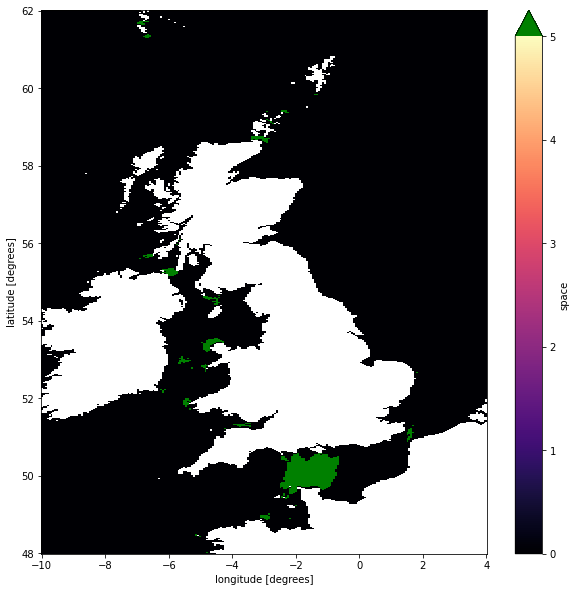

In [10]:
ds['lat'] = ds.lat.assign_attrs(units='degrees')
ds['lat'] = ds.lat.assign_attrs(long_name='latitude')
ds['lon'] = ds.lon.assign_attrs(units='degrees')
ds['lon'] = ds.lon.assign_attrs(long_name='longitude')

cmap = mpl.cm.get_cmap('magma').copy()
cmap.set_over('green')
cmap.set_bad('white')

ds.space.plot(size=10,aspect=1,vmax=5,cmap=cmap)  
# plt.savefig('figures/for-report/ga-searchspace-1e8.png')

In [19]:
ds = xr.open_dataset('data/processed/map.nc')
s_space = ds.empty.values
thres = pandas.read_csv('data/processed/5e7.csv')
thres = thres[thres['flag']=='s']

for j in range(len(thres)):
    s_space[thres.iloc[j]['lat_index'],thres.iloc[j]['lon_index']] = 10

In [20]:
placement_xr = xr.Dataset({
    'space': xr.DataArray(
        data=s_space,
        coords={'lat': latitude,
                'lon': longitude},
        dims=['lat','lon'])})



placement_xr.to_netcdf(path=f'data/processed/stream-search-space-5e7.nc')

In [21]:
ds = xr.open_dataset('data/processed/stream-search-space-5e7.nc')

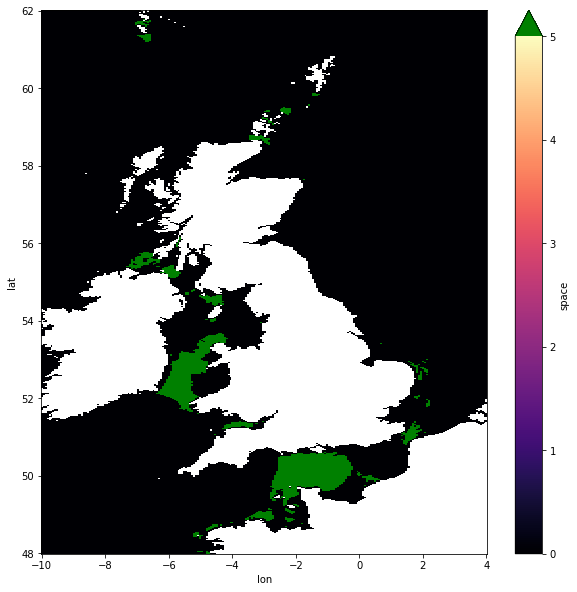

In [22]:
cmap = mpl.cm.get_cmap('magma').copy()
cmap.set_over('green')
cmap.set_bad('white')

ds.space.plot(size=10,aspect=1,vmax=5,cmap=cmap)  

In [ ]:
### initialise 1 chromosome

# def initialise(k):
#     '''
#     '''
#     df_idx = list(np.arange(not_nan.shape[0]))
#     rand_idx = np.array(sample(df_idx,k)) # random.sample: no repetition
#     df_sub = not_nan.iloc[rand_idx]
#     init_pop = np.zeros((r_pd.shape[0],k))
    
#     for i in range(k):
#         if df_sub.iloc[i,0] == 'r':
#             init_pop[:,i] = r_pd[:,df_sub.iloc[i,1],df_sub.iloc[i,2]]*r_area
            
#         elif df_sub.iloc[i,0] == 's':
#             init_pop[:,i] = s_pd[:,df_sub.iloc[i,1],df_sub.iloc[i,2]]*s_area
    
    
#     return init_pop,df_sub

   

In [ ]:
### inefficient

# def initialise(N,k):
#     '''
#     '''
#     df_idx = list(np.arange(not_nan.shape[0]))
#     df_pop = pandas.DataFrame(columns=['flag','lat_index','lon_index'])
#     init_pop = np.zeros((N,k,r_power.shape[0]))
    
#     for j in range(N):
#         rand_idx = np.array(sample(df_idx,k)) # random.sample: no repetition
#         df_sub = not_nan.iloc[rand_idx]
#         df_pop = pandas.concat(objs=[df_pop,df_sub])
    
#         for i in range(k):
#             if df_sub.iloc[i,0] == 'r':
#                 init_pop[j,i,:] = r_power[:,df_sub.iloc[i,1],df_sub.iloc[i,2]]

#             elif df_sub.iloc[i,0] == 's':
#                 init_pop[j,i,:] = s_power[:,df_sub.iloc[i,1],df_sub.iloc[i,2]]

    
#     return init_pop,df_pop


In [44]:
def initialise(N,k):
    '''
    random initial population
    '''
    
    init_pop = np.zeros((N,k),dtype=int)
    
    for i in range(N):
        chrom = np.array(sample(df_idx,k))
        init_pop[i,:] = chrom
    
    return init_pop

In [45]:
init_pop = initialise(20,5)

In [46]:
init_pop

array([[ 6508, 28147,  6027, 16145, 13821],
       [27461,   361, 25218,  5369,  2475],
       [ 8919,   159, 14815, 12260,  1555],
       [ 1900,  1263,  3268, 28128, 23681],
       [ 6502, 16262,  8563,  7302,  3617],
       [15149, 10578, 22017, 17943, 15258],
       [22759, 16807, 11100,     7, 10701],
       [14767, 17559,  7906,   960, 15234],
       [ 3357, 10293, 23665,  7837, 10450],
       [14723,  2727,  8436, 11590,  8583],
       [ 5795,  7192, 24132, 16749,  4422],
       [ 8311, 21602,  8325, 22915,  4622],
       [16707, 18216, 24882, 26082,  7011],
       [   18, 15143, 25907, 27112, 24963],
       [12935,  6793, 18087,  7962,  3091],
       [ 5132,  2991,  6704, 23867,  8257],
       [14898, 27846, 25060,  5856, 23868],
       [25384, 24816,   427, 10602,  4045],
       [ 2441, 11585, 26722, 16646, 16117],
       [ 3633,  8480,  9759,  4375, 13944]])

In [ ]:
### deprecated

# def fitness(pop):
#     '''
#     '''
#     f_val = np.zeros((pop.shape[0]))
#     for j in range(pop.shape[0]):
        
#         aggregate = 0
#         for i in range(pop.shape[1]):
#             aggregate += pop[j,i,:]

#         p_mean = np.mean(aggregate)
#         rmsd = np.sqrt(np.mean((aggregate-p_mean)**2))
#         f_val[j] = p_mean/rmsd
        
#     return f_val

In [47]:
def fitness(pop):
    '''
    '''
    
    f_pop = np.zeros((pop.shape[0]))
    
    for i in range(pop.shape[0]):
        df_chrom = thres.iloc[pop[i]] # use loc for global index (original index in dataframe)
        chrom_pow = np.zeros((pop.shape[1],r_power.shape[0]))
        
        for j in range(pop.shape[1]):
            if df_chrom.iloc[j,0] == 'r':
                chrom_pow[j,:] = r_power[:,df_chrom.iloc[j,1],df_chrom.iloc[j,2]]

            elif df_chrom.iloc[j,0] == 's':
                chrom_pow[j,:] = s_power[:,df_chrom.iloc[j,1],df_chrom.iloc[j,2]]
                
        aggregate = 0
        for j in range(pop.shape[1]):
            aggregate += chrom_pow[j,:]
            
        p_mean = np.mean(aggregate)
        rmsd = np.sqrt(np.mean((aggregate-p_mean)**2))
        f_pop[i] = p_mean/rmsd
        
        
    return f_pop


In [48]:
f = fitness(init_pop)
f

IndexError: positional indexers are out-of-bounds

In [ ]:
### deprecated

# def selection(pop,df_pop,f_val):
#     '''
#     tournament selection
#     '''
    
#     num_par = round(0.1*len(f_val))
#     f_idx = list(np.arange(len(f_val)))
    
#     parent = np.zeros((num_par,pop.shape[1],pop.shape[2]))
#     parent_id = pandas.DataFrame(columns=['flag','lat_index','lon_index'])
    
#     for i in range(num_par):
        
#         t_size = 5 # tournament size
#         randf_idx = np.array(sample(f_idx,t_size))
#         f_max = max(f_val[randf_idx]) # in outer loop/ga function, save these values
#         sel_idx = np.where(f_val==f_max)[0][0]
#         parent[i,:,:] = pop[sel_idx,:,:]
#         par_id = df_pop.iloc[sel_idx*pop.shape[1]:sel_idx*pop.shape[1]+pop.shape[1]]
#         parent_id = pandas.concat(objs=[parent_id,par_id])
        
#     return parent,parent_id

In [47]:
def selection(pop,f_pop):
    '''
    tournament selection
    '''
    
    num_par = round(0.3*len(f_pop))
    f_idx = list(np.arange(len(f_pop)))
    parents = np.zeros((num_par,pop.shape[1]),dtype=int)
    
    for i in range(num_par):
        t_size = 5 # tournament size
        t_idx = np.array(sample(f_idx,t_size)) # random indices of chromosomes in tournament
        f_max = max(f_pop[t_idx]) # max fitness of chromosomes in tournament
        p_idx = np.where(f_pop==f_max)[0][0] # index of fittest chromosome
        parents[i,:] = pop[p_idx,:] # fittest chromosome
        
    return parents

In [48]:
parents = selection(init_pop,f)

In [49]:
parents

array([[153378, 148299, 123562, 123897,  66429],
       [163703,   9070, 129284,  54640,  71449],
       [163703,   9070, 129284,  54640,  71449],
       [163703,   9070, 129284,  54640,  71449],
       [ 63370, 113512, 154146,  24767,  99734],
       [101840, 142117, 118923,  13419,  44531]])

In [ ]:
### deprecated

# def crossover():
#     '''
#     ring crossover
#     '''
    
#     pc = 0.7 # probability of crossover
#     cross_num = round(pc*parent.shape[0])
#     if cross_num%2 == 1:
#         cross_num +=1
        
#     pool_idx = list(np.arange(cross_num))  
#     randp_idx = np.array(sample(pool_idx,cross_num)) # pick the pool of parents for crossover
#     pool_df = parent_id.iloc[randp_idx]
#     pool = parent[randp_idx,:,:]
    
#     reprod_idx = []
#     for idx in pool_idx:
#         if idx not in randp_idx:
#             reprod_idx.append[idx]
#     reprod_idx = np.array(reprod_idx)
#     reprod_df = parent_id.iloc[reprod_idx]
#     reprod = parent[reprod_idx,:,:]
            
    
#     cross_idx = list(np.arange(pool.shape[0])
#     slice_idx = list(np.arange(parent.shape[1]))
#     offspring =
#     offspring_id =
                     
#     for i in range(pop.shape[0]-(parent.shape[0]-cross_num)):
    
#         randc_idx = np.array(sample(cross_idx,2)) # pick 2 parents randomly from pool for crossover
#         parent1 = pool[randc_idx[0],:,:]
#         parent2 = pool[randc_idx[1],:,:]
#         family_id = pool_df.iloc[randc_idx] # df is flattened, rehash id to be array of indices refernecing df
#         rands_idx = np.array(sample(slice_idx,1))
#         child1 = np.concatenate((parent1[:,rands_idx:,:],parent2[:,-rands_idx:,:]),axis=1)
#         child1_ida = 
#         child1_idb = 
#         child2 = np.concatenate((parent1[:,:rands_idx,:],parent2[:,:-rands_idx,:]),axis=1)
#         child2_id = 
        
#         # make sure to constrain such that all genes in one chromosome are unique
    

In [ ]:
### logic check

# # if num parents and cross num are even, reprod is even, num cross off is even
# if parents.shape[0]%2 == 0 and cross_num%2 == 0: 
#     pass
# # if num parents is even and cross num is odd, reprod is odd, num cross off is odd
# if parents.shape[0]%2 == 0 and cross_num%2 == 1:
#     cross_num += 1

# if parents.shape[0]%2 == 1 and cross_num%2 == 0:
#     cross_num += 1

# if parents.shape[0]%2 == 1 and cross_num%2 == 1:
#     pass


In [54]:
### look at ringbased crossover algorithms specifically for knapsack problems
### many ringbased crossover operators rely on bit shifts, which may not be relevant when the order of genes 
### in chromosome does not matter


def crossover(parents,pop):
    '''
    ring crossover
    '''
    
    pc = 0.7 # probability of crossover
    cross_num = round(pc*parents.shape[0]) # number of chromosomes used for crossover
    
    # want an even number offspring created from crossover
    # if num parents is even and cross num is odd, reprod is odd, num cross off is odd
    # if num parents is odd and cross num is even, reprod is odd, num cross off is odd
    if parents.shape[0]%2 == 0 and cross_num%2 == 1 or parents.shape[0]%2 == 1 and cross_num%2 == 0:
        cross_num = cross_num - 1
        
    
    par_idx = list(np.arange(parents.shape[0])) # indices of parents to select from 
    randp_idx = np.array(sample(par_idx,cross_num)) # random indices for pool of chromosomes used in crossover
    pool = parents[randp_idx,:] # pool of chromosomes used in crossover
    
    reprod_idx = []
    for idx in par_idx:
        if idx not in randp_idx:
            reprod_idx.append(idx)
    reprod_idx = np.array(reprod_idx)
    reprod = parents[reprod_idx,:] # remaining chromosomes not used in crossover to be passed unchanged to next gen
    
    
    cross_idx = list(np.arange(pool.shape[0])) # indices of pool to select from
    slice_idx = list(np.arange(1,pool.shape[1])) # indices of genes to select from, can't select zero which would be
                                                 # same as reproduction
    num_off = pop.shape[0]-reprod.shape[0] # number of chromosomes obtained from crossover (N-reprod)
    assert num_off%2 == 0
    
    children1 = np.zeros((int(num_off/2),pop.shape[1]),dtype=int)
    children2 = np.zeros((int(num_off/2),pop.shape[1]),dtype=int)
                    
    
    for i in range(int(num_off/2)):

        randc_idx = np.array(sample(cross_idx,2)) # pick 2 parents' indices randomly from pool for crossover
        parent1 = pool[randc_idx[0],:]
        parent2 = pool[randc_idx[1],:]
                     
        rands_idx = choice(slice_idx) # pick an index to slice genes
        
        child1 = np.concatenate((parent1[rands_idx:],parent2[-rands_idx:]))
        child2 = np.concatenate((parent1[:rands_idx],parent2[:-rands_idx]))
        
        children1[i,:] = child1
        children2[i,:] = child2
                     
    c_offspring = np.concatenate((children1,children2,reprod),axis=0)
        
    return c_offspring
        


In [55]:
off = crossover(parents,init_pop)

In [56]:
off

array([[129284,  54640,  71449,  54640,  71449],
       [  9070, 129284,  54640,  71449,  71449],
       [ 54640,  71449, 118923,  13419,  44531],
       [ 99734, 142117, 118923,  13419,  44531],
       [118923,  13419,  44531,  54640,  71449],
       [154146,  24767,  99734,  13419,  44531],
       [154146,  24767,  99734,  54640,  71449],
       [ 13419,  44531, 129284,  54640,  71449],
       [  9070, 129284,  54640,  71449,  99734],
       [163703,   9070, 163703,   9070, 129284],
       [163703, 163703,   9070, 129284,  54640],
       [163703,   9070, 129284, 101840, 142117],
       [ 63370, 113512, 154146,  24767, 101840],
       [101840, 142117, 163703,   9070, 129284],
       [ 63370, 113512, 101840, 142117, 118923],
       [ 63370, 113512, 163703,   9070, 129284],
       [101840, 142117, 118923, 163703,   9070],
       [163703,  63370, 113512, 154146,  24767],
       [153378, 148299, 123562, 123897,  66429],
       [163703,   9070, 129284,  54640,  71449]])

In [74]:
### sequential mutation method-look at this method specifically for knapsack problems
# for sequence mutation, will need to define position of mutation in outer ga loop
# is sequence mutation still relevant if position of genes does not matter?

def mutation(gen,offspring):
    '''
    sequential mutation method 
    '''
#     pm = 0.01 # probability of mutation

    # constraint such that all genes in one chromosome are unique
    for i in range(offspring.shape[0]):
        chrom = offspring[i,:]
        u_idx = [x for x in df_idx if x not in chrom]
        mut = choice(u_idx)
        chrom[gen] = mut
        
        if len(chrom) != len(np.unique(chrom)):
            new_chrom = np.unique(chrom)
            num_replace = len(chrom)-len(new_chrom)
            u_idx = [x for x in df_idx if x not in new_chrom]
            if num_replace == 1:
                rep_idx = np.array([choice(u_idx)])
            elif num_replace > 1:
                rep_idx = np.array(sample(u_idx,num_replace))
            chrom = np.concatenate((new_chrom,rep_idx))
            
        offspring[i,:] = chrom
           
            
        
    return offspring
    
    
    # constrain that one chromosome is not the exact same as another chromosome?

In [75]:
new_gen = mutation(0,off)

In [76]:
new_gen

array([[162029,  71449,  91462, 159872,  99050],
       [  2931,  54640,  71449, 129284,  17440],
       [ 91009,  71449, 118923,  13419,  44531],
       [ 66258, 142117, 118923,  13419,  44531],
       [149057,  13419,  44531,  54640,  71449],
       [154261,  24767,  99734,  13419,  44531],
       [ 87711,  24767,  99734,  54640,  71449],
       [ 25098,  44531, 129284,  54640,  71449],
       [  3806, 129284,  54640,  71449,  99734],
       [108526, 129284, 159797, 163703,  32705],
       [ 15748, 163703,   9070, 129284,  54640],
       [160667,   9070, 129284, 101840, 142117],
       [119498, 113512, 154146,  24767, 101840],
       [ 11686, 142117, 163703,   9070, 129284],
       [  4541, 113512, 101840, 142117, 118923],
       [111536, 113512, 163703,   9070, 129284],
       [ 42093, 142117, 118923, 163703,   9070],
       [137489,  63370, 113512, 154146,  24767],
       [ 89173, 148299, 123562, 123897,  66429],
       [ 18218,   9070, 129284,  54640,  71449]])

In [ ]:
### termination condition: number of generations and/or the average fitness value becomes constant